In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [14]:
cd ..

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [16]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from TileEM_plot_toolbox import *
from TileEM_Models import *
gamma_properties=False
DATA_DIR="sampletopworst5"
os.chdir(DATA_DIR)
try: 
    topTilePickHeuristic=sys.argv[1]
except(IndexError):
    topTilePickHeuristic="area"

topk = 40
training_tbl = []
my_BBG  = pd.read_csv("../../my_ground_truth.csv")
import itertools


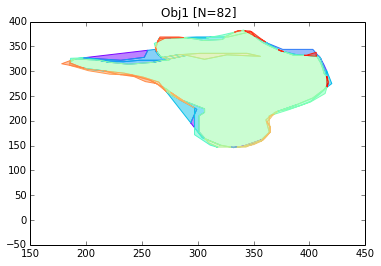

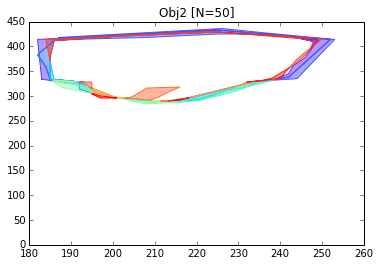

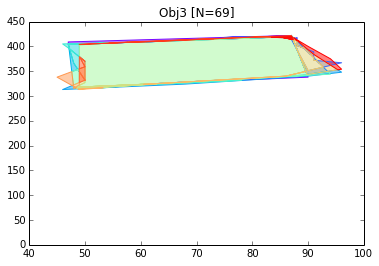

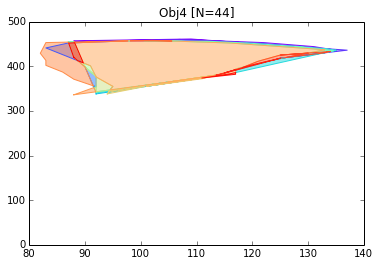

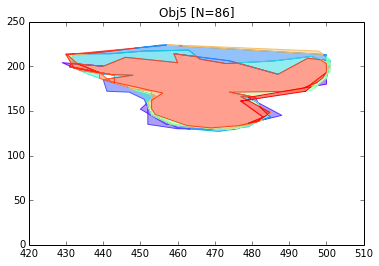

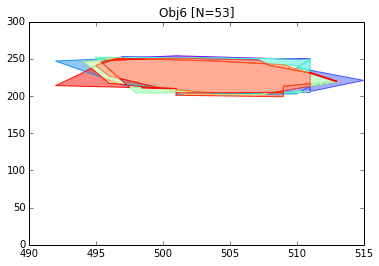

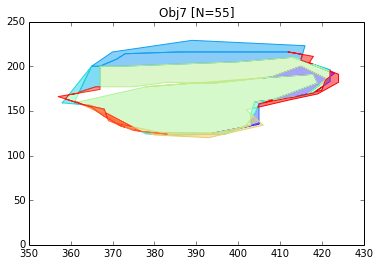

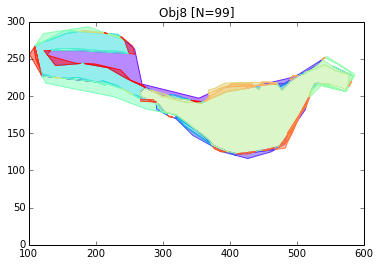

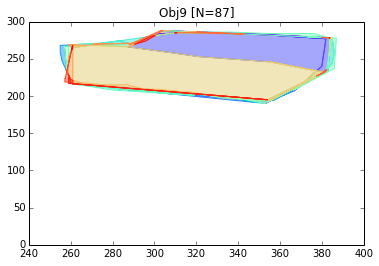

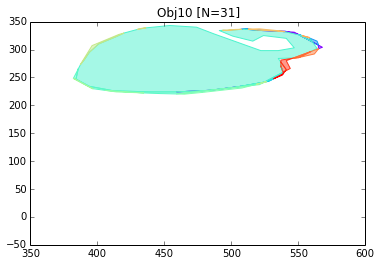

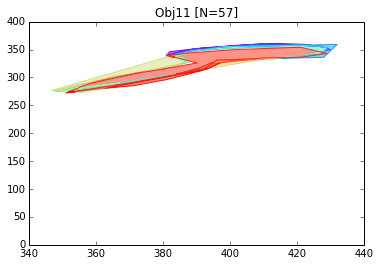

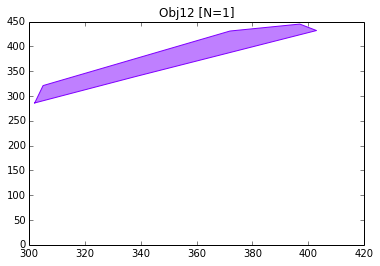

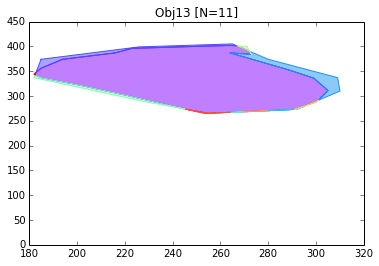

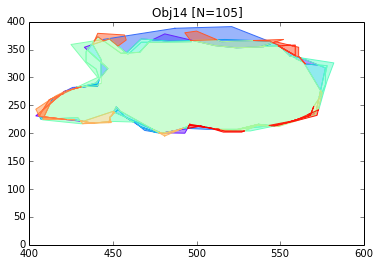

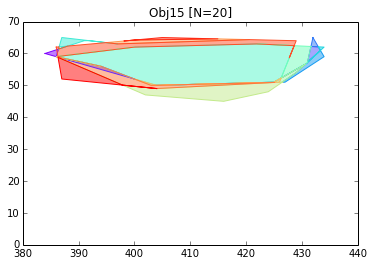

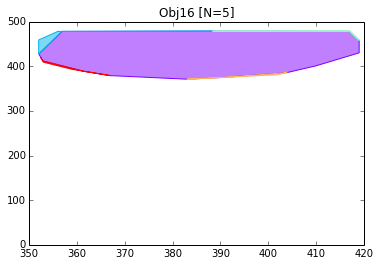

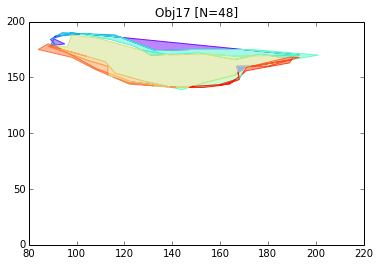

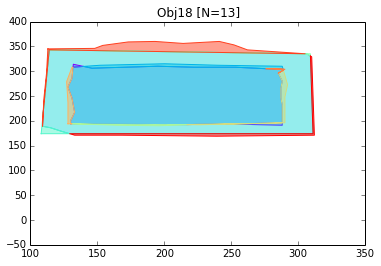

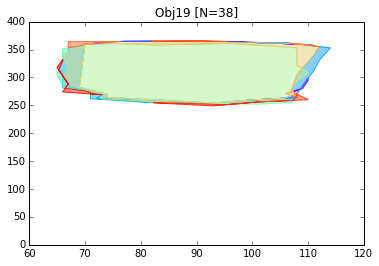

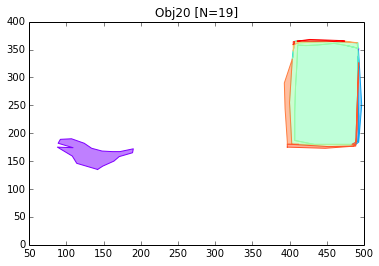

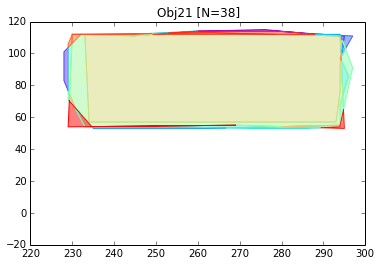

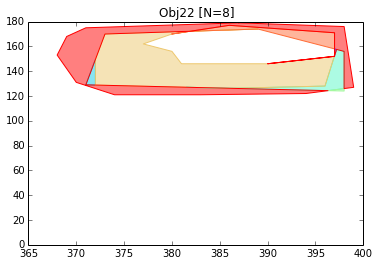

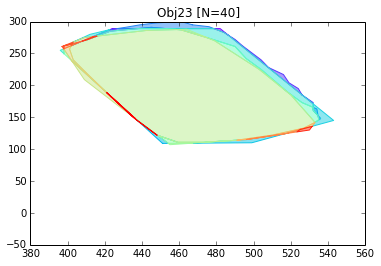

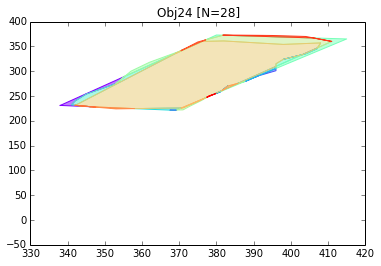

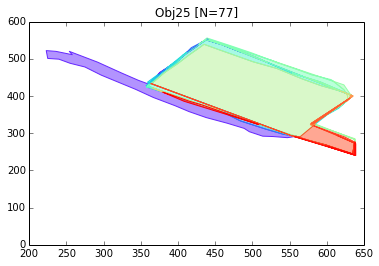

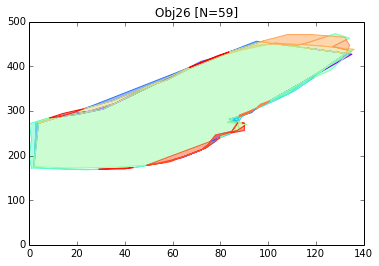

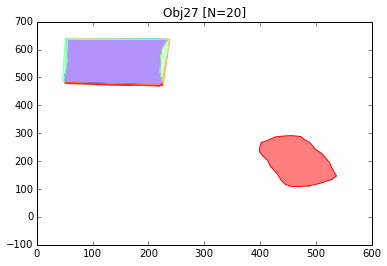

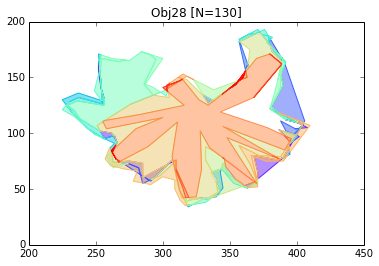

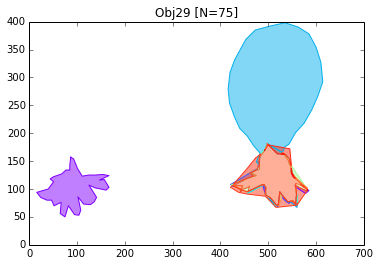

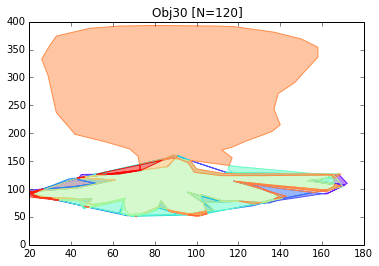

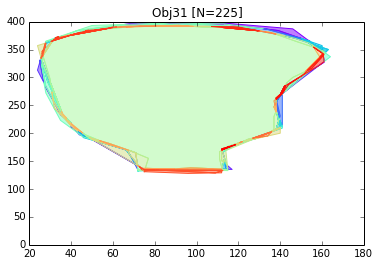

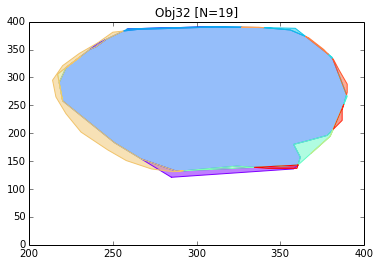

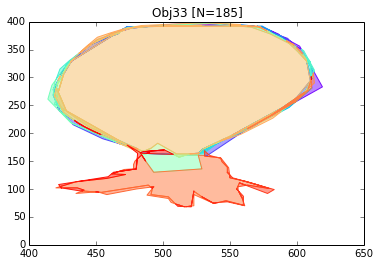

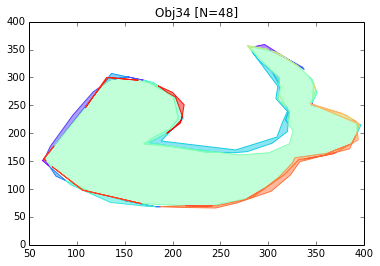

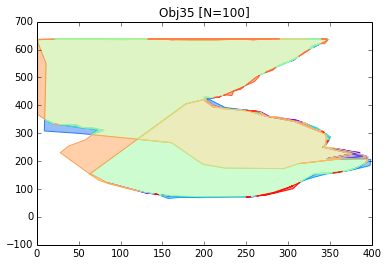

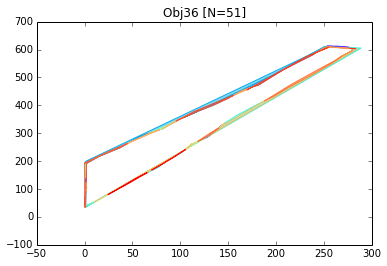

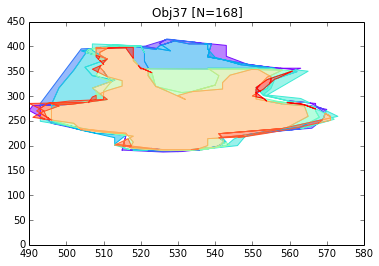

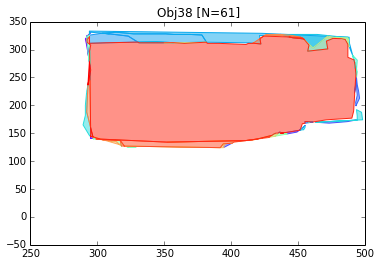

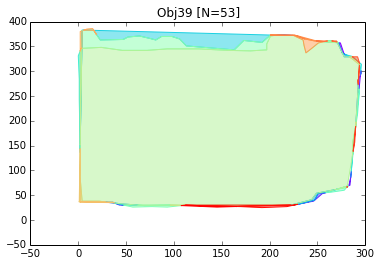

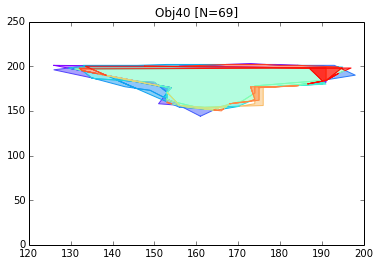

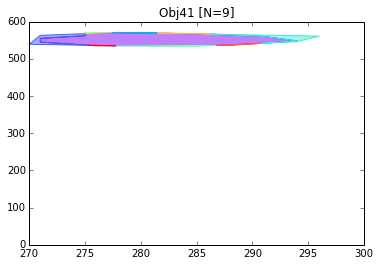

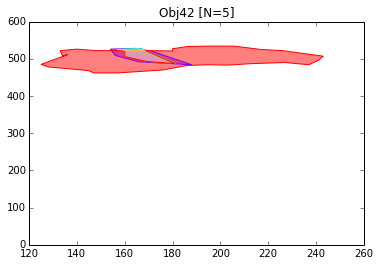

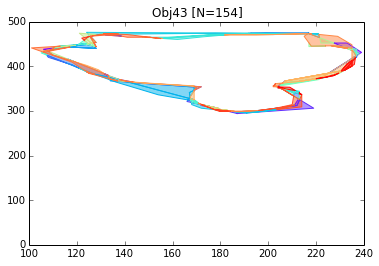

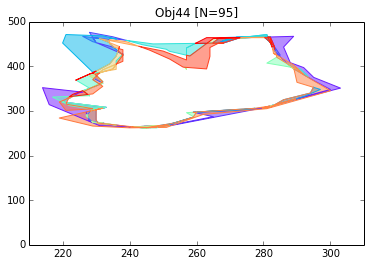

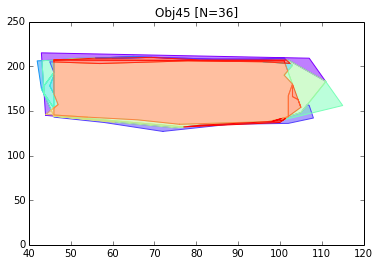

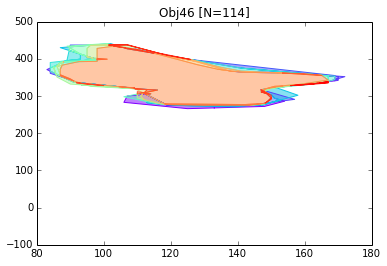

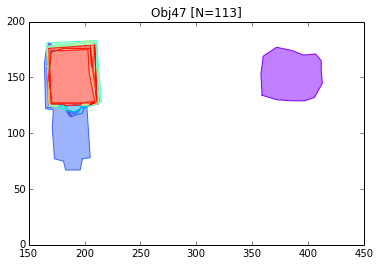

In [25]:
for objid in object_lst:
    tiles = pkl.load(open("vtiles{0}.pkl".format(objid),'r'))
    visualizeTilesSeparate(tiles)
    plt.title("Obj{0} [N={1}]".format(objid,len(tiles)))

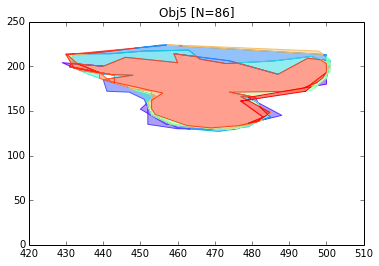

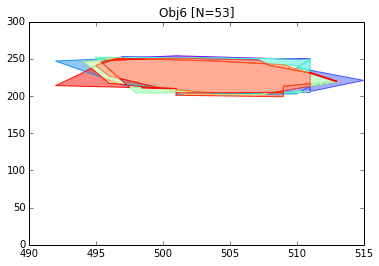

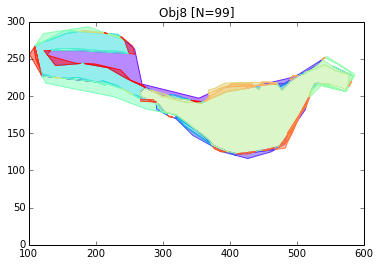

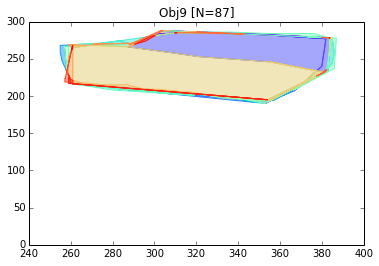

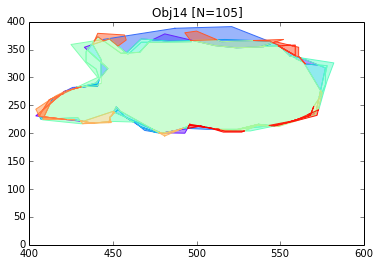

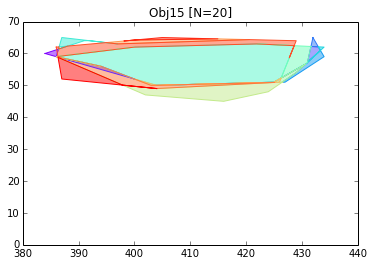

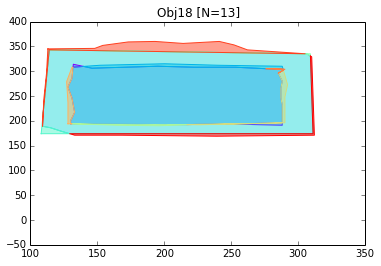

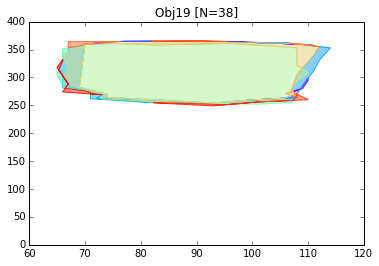

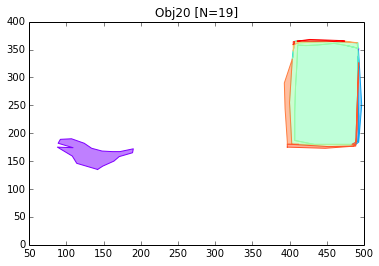

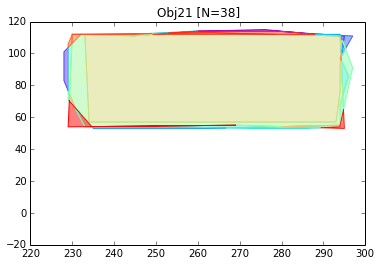

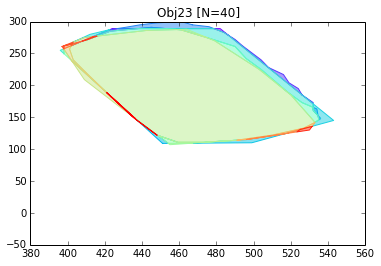

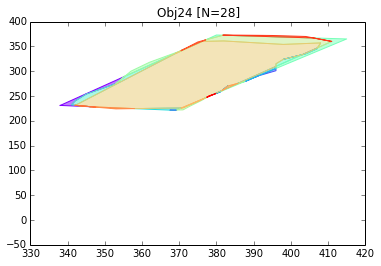

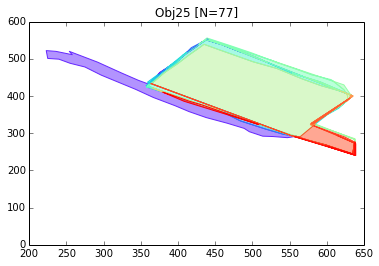

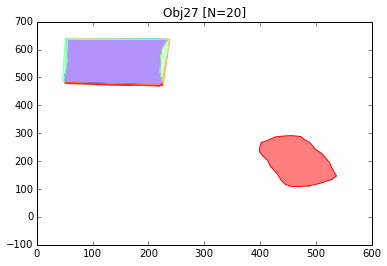

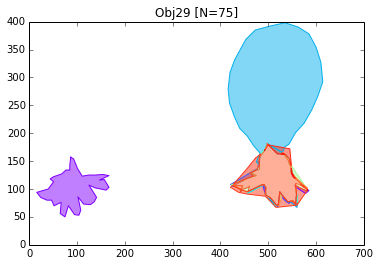

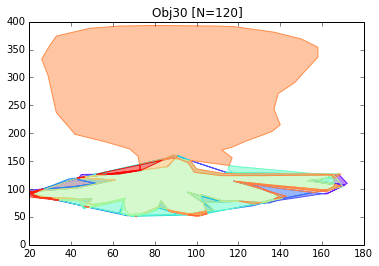

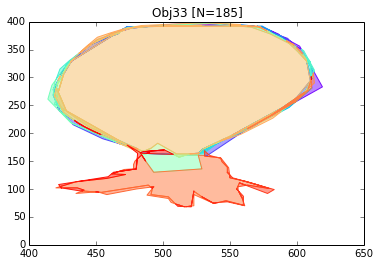

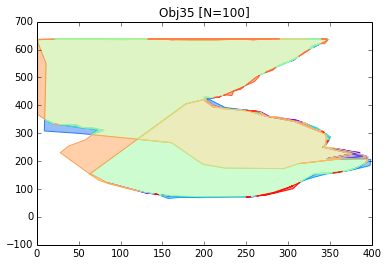

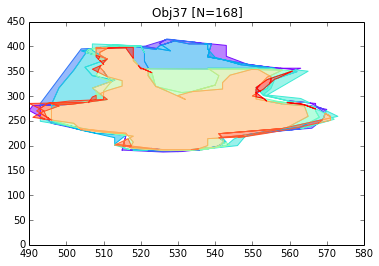

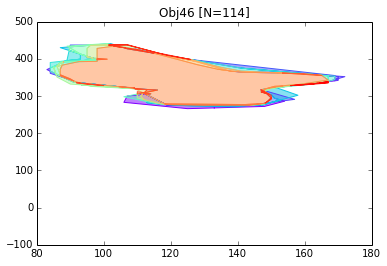

In [30]:
selected_objids=[ 5,  6,  8,  9, 14, 15, 18, 19, 20, 21, 23, 24, 25, 27, 29, 30,33, 35, 37, 46]
for objid in selected_objids:
    tiles = pkl.load(open("vtiles{0}.pkl".format(objid),'r'))
    visualizeTilesSeparate(tiles)
    plt.title("Obj{0} [N={1}]".format(objid,len(tiles)))

In [66]:
topTilePickHeuristic="area"

In [71]:
topk = 10
for objid in tqdm(selected_objids):
    # print "working on obj",objid
    #Get Tile information for that object
    #worker_ids,worker_precision_lst,worker_recall_lst = compute_worker_PR_obj(objid,return_worker_id=True)
    tiles = pkl.load(open("vtiles{}.pkl".format(objid),'r'))
    worker_ids = pkl.load(open("worker{}.pkl".format(objid),'r'))
    indicatorMat = pkl.load(open("indMat{}.pkl".format(objid),'r'))
    if gamma_properties : 
        gammas = pkl.load(open("gfile{}.pkl".format(objid),'r'))
        if  list(gammas[0])==[] and topTilePickHeuristic=='gamma' :
            print "No Gamma information for this object, going onto the next"
            continue

    #using the area information in the last row 
    tile_area = np.array(indicatorMat[-1])
    # Loop through all combinations of 20 randomly chosen tiles 
    tile_subset_idx = np.random.choice(np.arange(len(tiles)),topk)
    ground_truth_match = my_BBG[my_BBG.object_id==objid]
    x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
    BBG = shapely.geometry.Polygon(zip(x_locs,y_locs))
    tile_area_ratio = tile_area/BBG.area
    print "Picked top-k tiles"
    if topTilePickHeuristic=="area": 
        # Loop through all combinations of 40 top-area tiles 
        # print "area heuristic"
        tile_subset_idx = tile_area_ratio.argsort()[::-1][:topk]
    elif topTilePickHeuristic=="gamma":
        # print "gamma"
        tile_subset_idx = np.argsort(gammas[0])[::-1][:topk]
    elif topTilePickHeuristic=="majvote":
        # print "majvote"
        tile_votes = np.sum(indicatorMat[:-1],axis=0)
        tile_subset_idx = np.argsort(tile_votes)[::-1][:topk]
    print "Creating random subsets from topk tiles"
    rand_subset =[]
    for i in range(1000):#3000
        NumTilesInCombo= np.random.randint(1,topk)#at least one tile must be selected
        tidxInCombo= np.random.choice(tile_subset_idx,NumTilesInCombo,replace=False)
        rand_subset.append(tidxInCombo)
    print "Compute feature properties for T prime "
    for Tprime in rand_subset:
        p,r =compute_PR(objid,Tprime,tiles)
        gvals=[]
        experiment_idx=0
        # Majority Votes 
        region_votes=[]
        Tareas=[]
        for tidx in Tprime:
            #Number of votes for that tile
            region_votes.append(np.sum(indicatorMat[:-1][:,tidx]))

            if gamma_properties:
                if gammas!=[]:
                    gvals.append(gammas[experiment_idx][tidx])
                else:
                    gvals.append(0)

            Tareas.append(Polygon(tiles[tidx]).area)
        pTprime_val = pTprimeBasic(objid,Tprime,BBG)
        pTprimeLSA_val1 = pTprimeLSA(objid,Tprime,BBG,1)
        pTprimeLSA_val10 = pTprimeLSA(objid,Tprime,BBG,10)
        pTprimeLSA_val50 = pTprimeLSA(objid,Tprime,BBG,50)
        pTprimeLSA_val100 = pTprimeLSA(objid,Tprime,BBG,100)
        #if pTprime_val==0: break
        training_tbl.append([objid,Tprime,np.sum(region_votes), np.mean(region_votes),np.sum(gvals),np.mean(gvals),\
                             np.sum(Tareas),np.mean(Tareas),pTprime_val,pTprimeLSA_val1,pTprimeLSA_val10,pTprimeLSA_val50,\
                             pTprimeLSA_val100,p,r])


  0%|          | 0/20 [00:00<?, ?it/s]

Picked top-k tiles
area heuristic
Creating random subsets from topk tiles
Compute feature properties for T prime 


KeyboardInterrupt: 

In [68]:
df = pd.DataFrame(training_tbl,columns=["objid","T prime","Total Votes","Average Votes","Total gamma value","Average gamma value",\
                                         "Total area","Average area","pTprime","pTprime[Athres>1]","pTprime[Athres>10]",\
                                         "pTprime[Athres>50]","pTprime[Athres>100]","Precision","Recall"])
df.to_csv("all_tile_combo_metric_{}.csv".format(topTilePickHeuristic))

In [70]:
df

,objid,T prime,Total Votes,Average Votes,Total gamma value,Average gamma value,Total area,Average area,pTprime,pTprime[Athres>1],pTprime[Athres>10],pTprime[Athres>50],pTprime[Athres>100],Precision,Recall
0,5,"[66, 1]",29,14.500000,0,NaN,10.153129,5.076565,3.913685e-20,2.023747e-22,5.860670e-23,5.174536e-23,7.237678e-23,0.458434,0.001191
1,5,"[37, 49, 54, 65]",82,20.500000,0,NaN,54.102124,13.525531,1.084668e-47,5.440339e-41,3.205345e-41,1.800301e-42,1.253954e-42,0.989047,0.013698
2,5,[],0,NaN,0,NaN,0.000000,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000,0.000000
3,5,"[17, 54, 28, 69]",94,23.500000,0,NaN,202.282194,50.570549,1.282934e-44,4.150998e-46,7.929621e-47,1.685915e-43,5.106286e-41,0.991768,0.051355
4,5,"[19, 18, 67]",58,19.333333,0,NaN,40.578651,13.526217,2.322070e-41,1.923821e-32,1.365875e-33,7.380353e-36,5.003394e-36,0.719531,0.007474
5,5,[60],25,25.000000,0,NaN,15.454905,15.454905,4.555073e-14,5.114945e-12,5.578831e-11,5.590754e-12,4.809536e-12,0.478814,0.001894
6,5,"[22, 21, 28, 13]",72,18.000000,0,NaN,179.679813,44.919953,7.448770e-44,2.597324e-44,2.906984e-44,1.317788e-41,3.526449e-39,0.912493,0.041434
7,5,"[25, 51, 29]",59,19.666667,0,NaN,315.411611,105.137204,1.385714e-37,5.749082e-36,1.719384e-34,2.174439e-32,1.247635e-29,0.981576,0.079253
8,5,"[40, 30, 13]",29,9.666667,0,NaN,7.568389,2.522796,1.568799e-33,2.635947e-29,9.320740e-32,5.236565e-32,5.792348e-32,0.368992,0.000715
9,5,"[64, 67]",49,24.500000,0,NaN,34.399725,17.199863,4.793480e-26,6.231067e-23,1.450427e-21,3.210451e-23,2.191598e-23,0.745818,0.006567


In [59]:
len(tiles)

20

In [61]:
tile_area_ratio.argsort()[::-1][:topk]

array([ 8, 12, 17, 16, 19])

In [62]:
tile_subset_idx

array([46, 51,  6, 49, 20])

In [ ]:
NumTilesInCombo= np.random.randint(1,topk)#at least one tile must be selected
        tidxInCombo= np.random.choice(tile_subset_idx,NumTilesInCombo,replace=False)
        rand_subset.append(tidxInCombo)